# Component Fatigue Analysis

Uses stress-frequency response data to generate cycles to use complete form of Miner's Rule

# Requirements

Imports the necessary modules to run the code

In [1]:
import pandas
import numpy
import os
import random
import math
import cmath
import matplotlib.pyplot as plt
from PIL import Image
import colormaps as cmaps

# Define how long the vibration profile is (SECONDS)
full_time = 30

# Setting up the Directory

Create the necessary folders and explains where to put the data

To run this code, you must create a folder called "Data to Process" in the same directory as where this code is placed. This folder will be the folder where you place the raw csv data from the Solidworks frequency response probes. Alternatively, you can rename the folder to something else, but you will have to update the variable 'folder_name' (below) to the same name as the folder you want it in. 


Figure 1: Main Directory

Afterwards, place the csv data containing the frequency response from the Solidworks probe in the "Data to Process" folder (or whatever else you called it). 


Figure 2: Inside the "Data to Process" Folder (Initial Time)

NOTE: Running this script will create a new folder inside of the 'Data to Process' folder called 'Completed', so if this is NOT the first time you are running this code, this folder will be here, as well - this is perfectly acceptable. It is also okay if you want to create a 'Completed' folder beforehand, too - the code will function either way.


Figure 3: Inside the "Data to Process" Folder (Subsequent Time)


In [2]:
# *** INPUT *** Name of the local folder where the Solidworks response csv files are
folder_name = "Data to Process"

# Gets the current directory
main_dir = os.getcwd()

# Changes the directory to where the response csv files are
new_dir = main_dir+'\\'+folder_name
os.chdir(new_dir)

# Creates a 'Completed' folder if it doesn't exist already
completed_folder = new_dir + '\\Completed'
if not os.path.exists(completed_folder):
    os.makedirs(completed_folder)
    
# Creates a list of all the text files in the 
listy = os.listdir()
listy.remove('Completed')
filename = listy[0]

# Finds the main filename to base all the outputs off from
file_name_core = filename.split('.', 1)[0]
print("Name of Component: " + file_name_core)

Name of Component: T2 Transformer (Y-Axis)


In [3]:
# Creates a new folder for the pictures to export to
raw_pic_path = main_dir + '\\Rainflow Pictures'
if not os.path.exists(raw_pic_path):
    os.makedirs(raw_pic_path)

# Creates a folder inside the Rainflow_Pictures folder for the component
prt_pic_path = raw_pic_path + '\\' + file_name_core
if not os.path.exists(prt_pic_path):
    os.makedirs(prt_pic_path)

# Creates a folder inside the Rainflow_Pictures folder for the component
ind_pic_path = prt_pic_path + '\\Indivdual Pictures'
if not os.path.exists(ind_pic_path):
    os.makedirs(ind_pic_path)

# Fourier Transformation

Convert from frequency-domain to time-domain in order to derive Rainflow Matrix

## Extracting Data from the Solidworks CSV File

From my experience, the contents of the Soldiworks frequency response CSV file is inconsistent, so we will first re-format the contents to make it a consistent format for the code to work with.

<img src="https://raw.githubusercontent.com/a0kb0k/Thermal-Analysis-Pictures/main/PCB%20-%20Orientation.png" width="500"/>
Figure 4: Solidworks CSV File Contents

What this code block does is that it first searches for the first instance of the word "Point" that occurs in the file. This is the most consistent occurrence in all of the files and is usually indicative that the subsequent rows are the actual data points. So once the code finds the first instant of the word "Point", it then finds out what row number it is then removes all rows above it - since they are typically information on the analysis model - which we do not need for the Fourier transformation.


Figure 5: Re-formatted Solidworks CSV File Contents 

In case this code block does not work, you can always manually change the frequency response CSV file to match the format of Figure 4. Another cause of possible failure is if there are multiple probed points in the frequency response curve. Check to make sure that there are only 3 columns - a fourth or fifth or sixth column might appear if you selected multiple points during the probe in Solidworks.

In [4]:
# Opens the response graph
os.chdir(new_dir)
df = pandas.read_csv(filename)

# Searches for the first instance of the word 'Point' and removes any row before it
pol = df.loc[df.isin(['Point']).any(axis=1)].index.tolist()
for b in range(pol[0]+1):
    df = df.drop(b)

# Renames the remaining columns to their appropriate data
df.columns="Step,Frequency,Stress".split(",")
df['Step'] = df['Step'].astype(float)
df['Frequency'] = df['Frequency'].astype(float)
df['Stress'] = df['Stress'].astype(float)

### Verify the Data

This code block just plots the frequency response curve. The shape should look just like the response curve from the preview window of the Solidworks probe.

There are 231 datapoints in the curve.


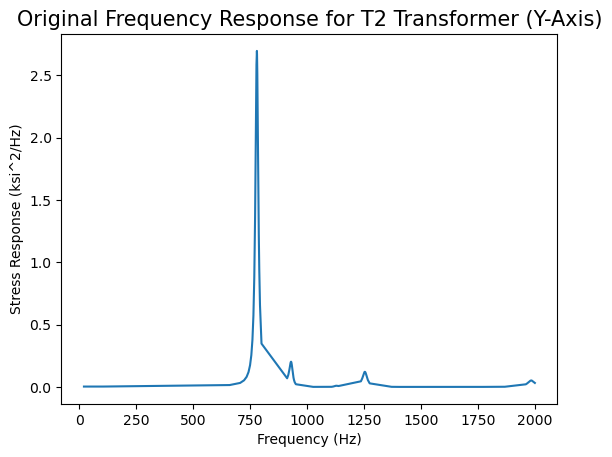

In [5]:
# Re-labels the columns
# Converts current data into a list (for validation purposes)
stress_0 = df['Stress'].tolist()
freq_0 = df['Frequency'].tolist()

# States how many PSD points there are
print('There are ' + str(df.shape[0]) + ' datapoints in the curve.')

# Plots the current data (for validation purposes)
os.chdir(ind_pic_path)
plt.plot(freq_0, stress_0, label=None)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Stress Response (ksi^2/Hz)")
plt.title("Original Frequency Response for "+ file_name_core, fontsize = 15)

# Saves the figure in the 'Individual Pictures' folder
plt.savefig(file_name_core+' - Random Frequency Domain.png')
plt.show()
os.chdir(new_dir)

## Processed Dataframe

Creates a new dataframe to store the data of the processed data (in case we need to recreate it)

In [6]:
df_freq = pandas.DataFrame()
df_time = pandas.DataFrame()

## Symmetrize the Data

Stress-frequency response graph from Solidworks is only defined for positive frequencies because it is a real signal - and for a real valued signal, the PSD has to be symmetric about the 0-Hz axis. This means that the stress-frequency response graph is a one-sided data, meaning that the negative frequency components are redundant (or mirrors of the positive frequencies). 

A new function is created to recover this lost data by symmetrizing the positive frequencies and responses about the 0-Hz axis.

Source: https://dsp.stackexchange.com/questions/47640/generating-a-timeseries-with-an-arbitrary-power-spectrum

In [7]:
# Need to symmetrize the PSD data since it only contains values for positive frequencies

# Input the positive, real signals from the PSD and outputs a corresponding symmetrized response
def symmetrize(freq, psd):

    # Verifies that the input data is complete vy verifying length of frequencies and energy are the same
    if len(freq) != len(psd):
        raise ValueError('Length of frequencies and energy vectors do not match. Frequency Length: ' 
                         + str(len(freq)) + '. Energy length: ' + str(len(psd)) + '.')
    
    # If the data is complete, symmetrizes it
    else:
        N = len(psd)

        # Symmetrizes the frequencies across the 0-Hz frequency
        symm_f = numpy.zeros(2*N-1)
        symm_f[0:N] = numpy.flipud(freq)
        symm_f[N:] = freq[1:]

        # Symmetrizes the energy across the 0-Hz frequency
        symm_e = numpy.zeros(2*N-1)
        symm_e[0:N] = numpy.flipud(psd)
        symm_e[N:] = psd[1:]
        
    return symm_f, symm_e   # Returns the symmetrized frequencies and energies, respectively

In [8]:
# Symmetrize the frequencies and stresses from the given PSD curve
symm_in_freq, symm_in_stress = symmetrize(freq_0, stress_0)

# Store the symmetrized frequencies and stresses
df_freq.insert(0, "Frequencies (Hz)", df.Frequency, allow_duplicates = True)
df_freq.insert(1, "Stress (Hz)", df.Stress, allow_duplicates = True)

## Phase Angles

The power spectral density calculation discards phase angles, so normally a PSD will not have a unique corresponding time history. 

However, for the purposes of calculating accumulated damage on the system, we will instead generate uniformly distributed, random phase angles for each of the data points. This will allow us to create a time history graph using a fourier transformation.

In [9]:
# Since the frequencies are mirrored across the 0-Hz frequency, phase angles need to be, as well

df_size = df.shape[0]
def gen_phase(N):
    # Generates phase angles if there is an even number of data points
    if N%2==0:
        phase = numpy.zeros(N)

        # Creates mirror of positive phase angles - which are for negative frequencies
        mirror = math.floor(N/2)    
        randoms = numpy.random.uniform(low=0, high=2*math.pi, size=mirror)

        # Generates normal distribution of phase angles from 0 to 2-pi radians
        phase[:mirror] = randoms
        phase[mirror+1:] = numpy.flipud(-randoms)
        
    # Generates phase angles if there is an odd number of data points    
    else:
        phase = numpy.zeros(N)

        # Creates mirror of positive phase angles - which are for negative frequencies
        mirror = math.floor(N/2)    
        randoms = numpy.random.uniform(low=0, high=2*math.pi, size=mirror)

        # Generates normal distribution of phase angles from 0 to 2-pi radians
        phase[:mirror] = randoms
        phase[mirror+1:] = numpy.flipud(-randoms)
    
    return phase

## Amplitude Calculation

Before we run the fourier transformation, we will need to derive the amplitudes of each data point.

The Power Spectral Density units are in (Amplitude)^2/Hz, so we need to convert it to the appropriate units for the time-domain curve. In this case, the units of the frequency response curve are in (ksi)^2/Hz since we want to get the stress response.

Given the Power Spectrum (P_k) between 0 < k < N points generated using a timeseries with timestep, h, and corresponding phase angle, a_k, the amplitude can be calculated as follows:

Equation
Citation: https://doi.org/10.1029/JA083iA04p01673

Once the amplitudes are calculated, we will then need to shift this curve due to how numpy implements the fourier transformation. Numpy will arrange it as having the zero frequency amplitude first, followed by the positive frequency amplitudes, then negative frequencies. In order to make this consistent with the original PSD (which is one-sided and symmetric about the 0-Hz) frequency, we use another numpy function to shift this curve such that the 0-Hz frequency is in the middle (with the negative- and positive- frequency amplitudes on the left- and right- side, respectively). 

Citation: https://dsp.stackexchange.com/questions/47640/generating-a-timeseries-with-an-arbitrary-power-spectrum

In [10]:
# Calculates pre-fft amplitude
def scale_psd(psd, dt):
    N = len(psd)

    # Generates random phase angles
    phase = gen_phase(N)
    
    # Calculates the amplitude for each frequency & phase angle - results in complex number
    A = numpy.sqrt(psd/(2*N*dt)) * numpy.exp(1j*phase)

    # Shift the zero-frequency component to the center of the spectrum.
    # B/c numpy puts the zero frequency followed by positive frequencies, then negative
    A_shift = numpy.fft.ifftshift(A)
    
    return A_shift, phase

In [11]:
# Checks for the maximum frequency from the PSD
F_max = df['Frequency'].max()

# Calculates time step (doubled since we have negative frequencies now)
dt = 1 / (2*F_max)

# Runs the amplitude function
PSD_scaled, Phase_Angles = scale_psd(symm_in_stress, dt)

# Creates the time steps
N = len(PSD_scaled)
t_max = (len(PSD_scaled)-1)*dt
time_input = numpy.linspace(0, t_max, num=N)

# Stores the time steps and ampltidues in case we need to re-create it
df_time.insert(0, "Time Step (sec)", time_input, allow_duplicates = True)
df_time.insert(1, "Phase Angles (rad)", Phase_Angles, allow_duplicates = True)
df_time.insert(2, "Amplitudes (ksi)", PSD_scaled, allow_duplicates = True)

## Run the Fourerir Transformation

Using the processed data (symmetrized, with phase angles, and scaled), we can run the fourier transformation. 

(NOTE: the numpy fft normalizes the data inherently, so we will not be normalizing the results).

In [12]:
# Convert to time-domain based on processed psd
def gen_timeseries(amp):
    
    psd_time = numpy.fft.fft(amp)

    # Gets the real component since time-domain can only be real
    # Okay to do this since the imaginary component is significantly smaller (and verified later)
    psd_time_real = numpy.real(psd_time)
    
    return psd_time_real, psd_time

# Runs the fourier transformation based on the processed psd curve
PSD_time, PSD_time_all = gen_timeseries(PSD_scaled)

# Stores the time-domain stresses in case we need to re-create it
df_time.insert(3, "Stress, Real (ksi)", PSD_time, allow_duplicates = True)
df_time.insert(4, "Stress, Imaginary (ksi)", PSD_time_all.imag, allow_duplicates = True)

# Validation

Validate that the synthesized time-domain curve is an appropriate estimate for the probed frequency response

## Parseval's Theorem

In order to validate the accuracy of the converted time-domain curve, we can apply Parseval's theorem, which states that the Fourier transformation is unitary - that the energy of a signal in the time- or frequency- domain is the same as the transformed signal in the frequency- or time- domain, respectively (preservation of this equality is the underlying reason why the sprectrum needs to be normalized). So if our fourier transformation is accurate, then the energy values should be the same from both domains.

Equation of the Parseval integral

Source: https://dsp.stackexchange.com/questions/67109/fft-one-sided-and-parseval-theorem

### Parseval Energy: Frequency-Domain

It was established that our frequency domain was a one-sided curve since the given PSD contained only real frequencies. Because of this, when we calculate the energy from the frequency domain, we can double the amplitudes on all points up to the Nyquist frequency (the threshold where data becomes aliased and irrecoverable) EXCEPT at the DC frequency (which is the first non-zero frequency data point from the curve) AND the Nyquist frequency itself, to get the curve's full energy value. 

The energy of the frequency domain is the total squared magnitude of the frequencies in range. Keep in mind that the frequency amplitudes are complex numbers, so the magnitude will be the square root sum of the amplitude multiplied by its complex conjugate. From there, we double this energy value for all frequencies up to the Nyquist frequency - except for the DC and Nyquist frequencies - then add them up.

Equation from the link - then expand the mangitude calc to show the complex conjugate and to show how the square root cancels with the squaring
But when calculating the energies, you multiply by the frequency step, which is the inverse of the time step, so it will be:
dt (from scaling) * dt (from complex conjugate) / dt (from frequency step) = dt

Since the frequency-domain curve does not undergo a fourier transformation, no normalization needs to be done to the energy calculation.

Finally, since we are essentially taking the integral of the energy curve, we multiply by the resulting energy value by the frequency step - which is the inverse of the time-step we used to make the time-domain curve (i.e. the inverse of double the maximum frequency from the PSD curve). The resulting product will be the complete Parseval energy value of the frequency-domain. 

In [13]:
# Calculates Energy of Original Curve (Frequency)
original_ESD = []
for i in PSD_scaled:

    # DC Frequency
    if len(original_ESD) == 0:
        original_ESD.append(i * numpy.conjugate(i))

    # Remaining positive frequencies that need to be doubled
    else:
        original_ESD.append(2 * i * numpy.conjugate(i))

# Scaling Factor (or the frequency step in the integral)
gf = dt 

# Parseval's Energy Calculation
ESD_freq = numpy.real(numpy.sum(original_ESD)) * gf
ESD_freq_value = numpy.round(ESD_freq, 5)

### Parseval Energy: Time-Domain

Like the energy of the frequency domain, the energy of the time domain is the total squared magnitude of all the time steps. Since all of the amplitudes and timesteps are real in the time-domain, the magnitude of the amplitudes is the square root sum of the squares. However, since the Parseval energy calculation requires us to square the totals, the square-root from the magnitude calculation cancels out with the square from the energy calculation - leaving the final energy calculation of the time-domain to be the cumulative sum of the squares of its amplitudes across all the timesteps.

Equation from the link - show how the magnitude square root cancels out with the squaring from the energy calculation

Finally, since we are essentially taking the integral of the energy curve, we multiply by the resulting energy value by the time differential - which was derived when calculating the time-domain curve. 

Unlike the frequency-domain curve, the time-domain curve needs to be normalized since it underwent a fourier transformation (and numpy inherently does NOT normalize when it calculates). This normalization factor is applied to the end result (i.e. same time we multiply by the time differential).

(When you sample above the Nyquist frequency, it becomes aliased, so anything higher than the Nyquist frequency gets aliased to a frequencies below the Nyquist - for example, if we have a 20-Hz Nyquist, and we ahve data at 30-Hz, then the 30-Hz signal gets mapped somewhere at the 1-Hz frequency and becomes indistinguishable. So whenever we try to reproduce data, we need to make sure we are sampling at lower frequencies - typically woth a low-pass filter. The way it is aliased is not random either - it seems to be a mirror about the Nyquist frequency.)

In [14]:
# Calculates Energy of the fft Curve (Time)
transformed_ESD = []
for j in PSD_time:
    # To calculate energies in the time-domain, just square it since it is already real

    transformed_ESD.append( j **2)

# Multiply by time step and need to normalize since the data underwent a transformation
# And the numpy fft does not do this inherently (hence dividing by df.shape[0]
gt = dt / df.shape[0]

# The energy is calculated by summing all of the energies and multiplying by the scaling factor (just like a derivative)
ESD_time = (numpy.sum(transformed_ESD)) * gt
ESD_time_value = numpy.round(ESD_time, 5)

### Parseval Energy: Difference

In order to validate the converted time-domain curve, Parseval's theorem should hold true - that is, the energy from both the time- and frequency- domain curves should both be the same value. However, when we calculate them, we see that they are not exactly the same. 

This is to be expected, however, since our frequency-domain curve was derived from a probe (i.e. Solidworks Simulation). This is because a probe will capture all signals at all frequencies - even those above the Nyquist frequency. Since we know that a difference should be apparent, there are a few things we can do to validate the accuracy of the model still. 

#### Parseval Energy: Difference, Frequency > Time

We know that the frequency-domain curve might have signals above the Nyquist frequency (since it is a probe gathering "real" data) and that the time-domain signals will not have any aliased signals (due to how this script derived it). The first check that we can do is verify that the energy from the frequency-domain is higher - if not equal - to the time-domain energy. And this will let us know that the time-domain data doesn't have any extra energy/aliased terms added to it.

In [15]:
# Prints the energy values for quick verification
print("Energy of Frequency-Domain: " + str(ESD_freq_value))
print("Energy of Time-Domain: " + str(ESD_time_value))
print("\n")

# Checks to see if the Frequency Domain has more energy than Time Domain
pass_criteria_1 = 0
if ESD_freq_value >= ESD_time_value:
    pass_criteria_1 += 1
    print("PASS: Energy of Frequency-Domain is HIGHER than the energy from the Time-Domain")
    print("\n")
else:
    print("FAILED: Energy of Frequency-Domain is LOWER than the energy from the Time-Domain")
    print("\n")

Energy of Frequency-Domain: 0.17322
Energy of Time-Domain: 0.17285


PASS: Energy of Frequency-Domain is HIGHER than the energy from the Time-Domain




#### Parseval Energy: Difference, Magnitude of Error

Another way we can verify the time-domain curve is by making sure that the error between the two energies matches with the signal profile we see from the frequency response curve. If we see that the signal amplitude above the Nyquist frequency from the Solidworks response curve is close to zero (meaning that the system and/or component did not reach resonance), then we can expect the error to be small. However, if we see that the profile is drastically high, then we can expect a large error. In the case of the latter, this approach might not be appropriate and the simulation might have to be re-ran at a higher frequency (preferrably more than double what the resonant frequency is) in order to shift the Nyquist frequency up.

Figure: Example of Low Magnitudes above Nyquist Frequency

This can be verified quantitatively by checking the difference in magnitudes from both the frequency- and time- domain curves. If the error between the two is small (<1%), then we can tell that there are no signficant signals above the Nyquist frequency from the frequency-domain curve (which is where out time-domain curve was derived from).

In [16]:
# The difference can be attributed to the energies above the Nyquist frequency
# Which cannot be reconstructed when making a sample - i.e. the fft transformation
ESD_diff = numpy.round( (ESD_freq - ESD_time) / (ESD_freq) * 100, 2 )

# Prints the energy values for quick verification
print("Energy of Frequency-Domain: " + str(ESD_freq_value))
print("Energy of Time-Domain: " + str(ESD_time_value))
print("\n")

# Checks to see if the difference is magnitudes is less than 1%
pass_criteria_2 = 0
if ESD_diff < 1:
    pass_criteria_2 += 1
    print("PASS: Error Between Energies is < 1%\n" + "      Energy Differences: " + str( ESD_diff ) + "%")
    print("\n")
else: 
    print("FAILED: Error Between Energies is Significant\n" + "      Energy Differences: " + str( ESD_diff ) + "%")
    print("\n")

Energy of Frequency-Domain: 0.17322
Energy of Time-Domain: 0.17285


PASS: Error Between Energies is < 1%
      Energy Differences: 0.21%




### Parseval Energy: Validation

We can then validate that the fourier transformation to convert the frequency-domain response to a time-domain response is valid by verifying that the two previous conditions are fulfilled - that the difference in magnitude between the energy from the frequency-domain is sufficiently close (if not slightly larger) to that of the energy from the time-domain. 

In [17]:
# Prints the PASSING results
if pass_criteria_1 + pass_criteria_2 == 2:
    print("\n")
    print("PASS: Parseval's theorem is valid for both domains.\n" + 
          "      Energy of Frequency-Domain: " + str(ESD_freq_value) + "\n" + 
          "      Energy of Time-Domain: " + str(ESD_time_value))
    print("\n")

# Prints the FAILING results
else:
    print("\n")
    print("FAIL: The following criteria was not met:\n")
    
    # Checks to see if time is higher than freq is the failing condition
    if ESD_diff > 1:
        print("      Error Between Energies is Significant\n" + "      Energy Differences: " + str( ESD_diff ) + "%")
    
     # Checks to see if the magnitude error is the failing condition
    if ESD_freq_value <= ESD_time_value:
        print("      Energy of Frequency-Domain is LOWER than the energy from the Time-Domain")




PASS: Parseval's theorem is valid for both domains.
      Energy of Frequency-Domain: 0.17322
      Energy of Time-Domain: 0.17285




## Curve Agreement

For a more qualitative validation of the synthesized time-domain curve we generated, we can compare the shape of the transformed synthesized curve to the original curve. With the newly derived time-domain data, we can convert it back to the frequency domain using an inverse fourerier transformation and checking to see if the curve matches with the original frequency-domain data.

To do this, we first take the inverse fourier transformation of the time-domain curve. We then re-calculate the amplitude of the curve by solving for the Power Spectrum term, Pk, from the time-series amplitude calculation below. It is important to note that since the full terms of the synthesized time-series data contain complex numbers, instead of simply squaring the term to get their magnitude, we will be multiplying it by their complex conjugates instead.

There are three scaling factors that need to be added to the inverse-fourier transformed data. The first is to multiply the term by the number of data points used - and this is done since we have to 'de-normalize' the data becausewe ran numpy's version of the inverse fourier transformation - and we want to compare it to real data. The second scaling factor is to just multiply this data by 2 since we want to take into account the energy from the negative frequencies. And the last term is to multiply the terms by the frequency differential since we are dealing with the frequency-domain. 

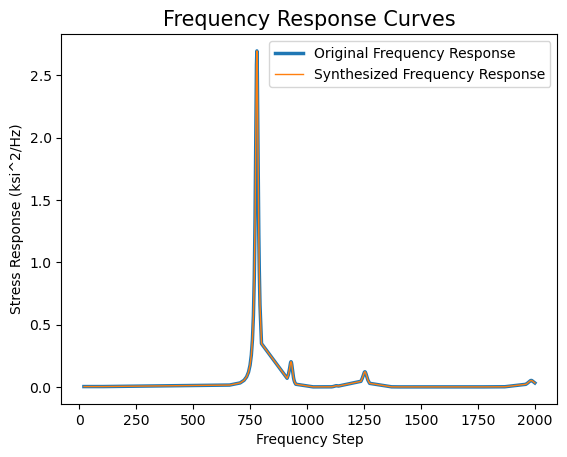

In [18]:
inversed_psd_time = numpy.fft.ifft(PSD_time)

validation_counter = 0
validation_N = []
while validation_counter < N/2:

    # Going from 0-Hz to Nyquist frequency b/c already shifted in the 'scale_psd' function
    N_index = inversed_psd_time[validation_counter]
   
    # REMEMBER THE TIMES 2 IS IN THE EQUATION FROM THE WEBSITE
    N_valuer = (N_index * numpy.conjugate(N_index))

    # Un-normalize the results since numpy inherently normalizes
    validation_N.append(N_valuer.real * 2 * gf * len(inversed_psd_time) )
    
    validation_counter += 1
    
plt.title("Frequency Response Curves", fontsize=15) 
plt.plot(freq_0, stress_0, linewidth = 2.5, label='Original Frequency Response')
plt.plot(freq_0, validation_N, linewidth = 1, label='Synthesized Frequency Response')
plt.legend()
plt.xlabel("Frequency Step")
plt.ylabel("Stress Response (ksi^2/Hz)")

os.chdir(ind_pic_path)
plt.savefig(file_name_core+' - Curve Comparison.png')
plt.show()
os.chdir(new_dir)

The agreement between the two curves is excellent since our synethesized inverse-fourier transformed time-domain curve aligns very closely with the original curve. It is important to note that while the curves look almost identical, the synethsized frequency response curve will tend to have very subtle shifts in the data points. This is because in the actual probed frequency response curve, the frequency differential was not constant - but it was made constant as a byproduct of us choosing a constant time-differential during the time-domain synthesis. However, since none of these shifts are outstanding - and because Parseval's energy theorem holds between the original and synthesized curves - the synthesized time-domain curve can be considered a good estimate for the probed frequency response data. 

## Time-Domain Plot

With the time-domain curve validated using Parseval's theorem, we can generate the time-domain plot. The data is already scaled - and normalized where appropriate. The energy spectral density data (i.e. Parseval's theorem) is displayed as a subtitle for convenience.

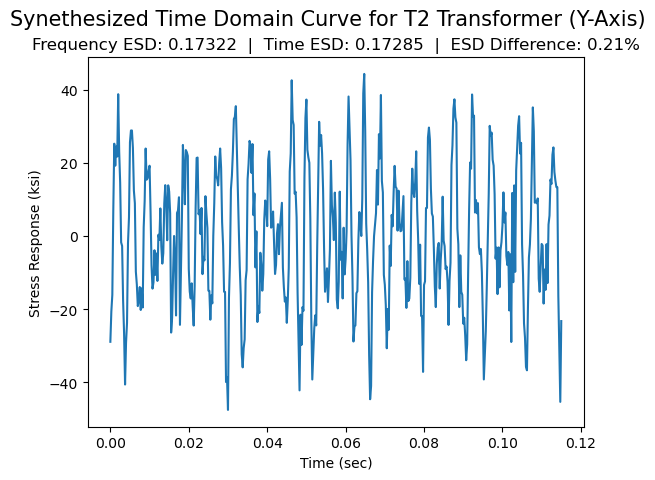

In [19]:
# Generate the time domain curve
os.chdir(ind_pic_path)
plt.plot(time_input, PSD_time)
plt.xlabel("Time (sec)")
plt.ylabel("Stress Response (ksi)")

# Names the title and puts the Parseval energy values as a subtitle for quick verification
plt.suptitle("Synethesized Time Domain Curve for "+file_name_core, fontsize=15)
plt.title("Frequency ESD: "+str(ESD_freq_value)+"  |  Time ESD: "+str(ESD_time_value)+"  |  ESD Difference: "+str( ESD_diff ) + "%") 

# Saves the figure in the 'Individual Pictures' folder
plt.savefig(file_name_core+' - Random Time Domain.png')
plt.show()

## Save the Dataframes

Saves the information from the frequency domain (which is just the data from the Solidworks frequency response curve, but formatted) and the time domain (which has 'double minus 1' data points as the frequency domain (because of the symmetrization about the 0-Hz frequency) and has phase angle, amplitude, and stress (real and imaginary) data saved). 

The most important data being recorded here is the phase angle information in the time-domain dataframe. Recall from earlier that PSD curves drop all information about the phase angles - which is why we randomly generated them (but in a uniform distribution), because this was a random vibration curve. If we save these randomly generated phase angles, then we will be able to recreate this exact time-domain curve at any time. In case there are any questions later on or if we need to re-do some calculations, saving these phase angles will allow us to recreate the data that we currently have. The rest of the data from the time-domain dataframe can be derived again with just the phase angle information and the initial frequency response data.

In [20]:
os.chdir(ind_pic_path)

# Creates the name of the files (saving as variable so we can recall the file later on in the script)
output_name_freq = file_name_core + " - Data, Frequency.csv"
output_name_time = file_name_core + " - Data, Time.csv"

# Saves the dataframe as an excel file
df_freq.to_csv(output_name_freq, index=False)
df_time.to_csv(output_name_time, index=False)

os.chdir(new_dir)

# Signal Processing

ASTM E1049 “Standard Practices for Cycle Counting in Fatigue Analysis” using "PSD_time" results

## General Data

Reads the time-domain dataframe and calculates behaviors and useful values from it. This information will be saved to the final excel file at the end.

In [21]:
# Reads the processed time dataframe
os.chdir(ind_pic_path)

# Calculates total time range of the converted time-domain
os.chdir(prt_pic_path)
total_time = df_time["Time Step (sec)"].max()-df_time["Time Step (sec)"].min()

# Checks the max and min stress and time
stress_min = round(df_time["Stress, Real (ksi)"].min(), 5)
stress_max = round(df_time["Stress, Real (ksi)"].max(), 5)
time_max = df_time["Time Step (sec)"].max()

# Calculate bin size (for discretization) and hysteresis gate
max_bin = (stress_max-stress_min)/256     # Because minimum of 64 bins is required, doing an extra power of 2
hysteresis_gate = (stress_max-stress_min)*0.02

# Prints the data summary
print("Measurements:", df_time.shape[0])
print("Min stress:", stress_min)
print("Max stress:", stress_max)
print("Range:", round(stress_max-stress_min,5))
print("Bin size:", round(max_bin, 5))
print("Hysteresis Gate:", round(hysteresis_gate, 5))
print("Time Range:", round(time_max, 5))

Measurements: 461
Min stress: -47.58247
Max stress: 44.40342
Range: 91.98589
Bin size: 0.35932
Hysteresis Gate: 1.83972
Time Range: 0.115


In [22]:
# Storing the titles to export to csv file later
result_titles = ['Measurements',
                 'Min Stress',
                 'Max Stress',
                 'Stress Range',
                 'Bin Size',
                 'Hysterisis Gate',
                 'Time Range']

# Storing the data summaries to export to csv file later
result_values = [df_time.shape[0],
                 stress_min,
                 stress_max,
                 round(stress_max-stress_min,5),
                 round(max_bin, 5),
                 hysteresis_gate,
                 time_max]

## Hysteresis Filtering

Hysteresis filtering is done to remove very small cycles from the time-domain curve that controbute negligible amount of damage. This is done by defining a hysteresis gate - which is usually a percentage of the stress range. In this case, we defined a hysteresis gate of 2% of a component's stress range.

Figure: Hysteresis Filtering

This filter checks to see the direction of the curve chronologically and notes when the direction/slope changes - calling this continuous group of points with same-sign slope a 'cycle'. Any cycle that has an amplitude smaller than this hysteresis gate size is removed from the time-domain data and all proceeding points are shifted down (towards the initial time step). This means that if a turning point is smaller than the hysteresis gate size, it is eliminated from the time history. 

Citation: https://help.3ds.com/2019/English/DSSIMULIA_Established/FesafeFatigueTheoryPdf/FesafeFatigueTheory.pdf

In [23]:
def hysteresis_filtering( data, gate ):
    # Creates copy of data to make sure original is intact
    ftr = data.copy(deep=True)

    # Initializes new variables and lists
    i = 0
    to_drop = []

    # Checks to see if two adjacent time-domain points are within the hysteresis gate range
    # Stores the index of the right-most point if it does
    while i < len(data):
        j = 1
        try:
            while abs(ftr[i+j] - ftr[i]) < gate:
                to_drop.append(i+j)
                j += 1
            i = i+j
        except:
            break

    # Removes the hysteresis points using their indices
    # Removes the data in reverse order - ensures that the indices are intact when point is removed
    for b in sorted(to_drop, reverse=True):
        del ftr[b]

    # Saves the length of the pre- and post- filtering data to show how many points were filtered
    input_len = len(data)
    output_len = len(ftr)

    return ftr, input_len, output_len

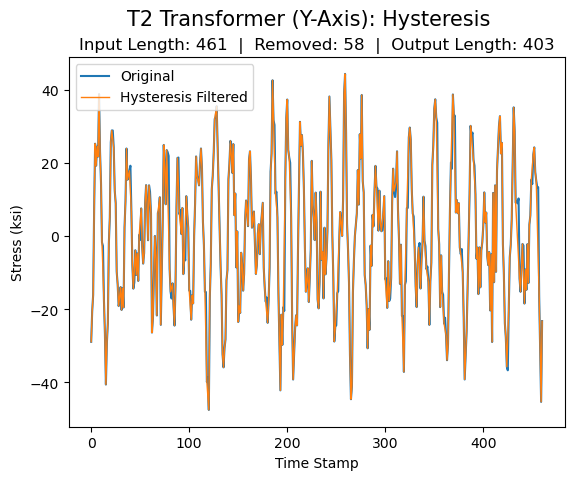

In [24]:
# Hysteresis gate size of about 2% of the maximum signal range is often an appropriate value
# https://help.3ds.com/2019/English/DSSIMULIA_Established/FesafeFatigueTheoryPdf/FesafeFatigueTheory.pdf

filtered_hysteresis, input_hyst, output_hyst = hysteresis_filtering( df_time["Stress, Real (ksi)"], hysteresis_gate )

# Generates a the filtered curve over the original curve
plt.plot(df_time["Stress, Real (ksi)"], label = 'Original')
plt.plot(filtered_hysteresis, label = 'Hysteresis Filtered', linewidth=1)
plt.legend()
plt.xlabel("Time Stamp")
plt.ylabel("Stress (ksi)")

# Names the title and puts the data on the filtered data as the subtitle for quick verification
plt.suptitle(file_name_core + ": Hysteresis", fontsize = 15)
plt.title("Input Length: "+str(input_hyst)+"  |  Removed: "+str(input_hyst-output_hyst)+"  |  Output Length: "+str(output_hyst)) 

# Saves the figure in the 'Individual Pictures' folder
os.chdir(ind_pic_path)
plt.savefig(file_name_core+' - Hyst.png')
plt.show()

## Peak-Valley Filtering

This is sometimes referred to as 'turning point sequencing'. When doing fatigue life calculations, only the reversals (in direction/slope) are relevant. 

Figure: Peak-Valley Filtering

Using the same definition of a 'cycle' as defined in the "Hysteresis Filtering" section, the filter notes the maximum and minimum values of the cycle and removes any points that are in between - as they are not relevant for the fatigue calculation. 

Citation: https://community.sw.siemens.com/s/article/rainflow-counting

In [25]:
def peak_valley_filtering( data ):
    # Creates copy of data to make sure original is intact
    ftr = data.copy(deep=True)

    # Initializes new variables and lists
    i = 1
    to_drop = list()

    # Calculates the keys (or in this case index?)
    idx = data.keys()

    # Checks to see if the a time-domain point is a peak or valley
    orientation_prev = "down" if ftr[idx[1]] < ftr[idx[0]] else "up"
    while i < len(data)-1:
        orientation = "down" if ftr[idx[i+1]] < ftr[idx[i]] else "up"
        if orientation_prev == orientation:
            to_drop.append(idx[i])
        else:
            orientation_prev = orientation
        i=i+1

    # Drops any of the points that are not a peak or valley (s/b a lot)
    ftr.drop(to_drop,inplace=True)

    # Saves the length of the pre- and post- filtering data to show how many points were filtered
    input_len = len(data)
    output_len = len(ftr)
    
    return ftr, input_len, output_len

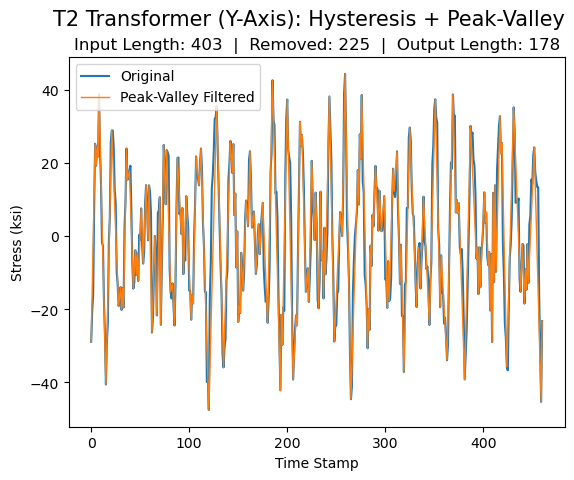

In [26]:
filtered_pv, input_pv, output_pv = peak_valley_filtering( filtered_hysteresis )

# Generates a the filtered curve over the original curve
plt.plot(df_time["Stress, Real (ksi)"], label = 'Original')
plt.plot(filtered_pv, label = 'Peak-Valley Filtered', linewidth=1)
plt.legend()
plt.xlabel("Time Stamp")
plt.ylabel("Stress (ksi)")

# Names the title and puts the data on the filtered data as the subtitle for quick verification
plt.suptitle(file_name_core + ": Hysteresis + Peak-Valley", fontsize = 15)
plt.title("Input Length: "+str(input_pv)+"  |  Removed: "+str(input_pv-output_pv)+"  |  Output Length: "+str(output_pv)) 

# Saves the figure in the 'Individual Pictures' folder
os.chdir(ind_pic_path)
plt.savefig(file_name_core+' - Hyst + PV.png')
plt.show()

## Discrerization

Discretization is needed in order to perform the actual rainflow counting procedure. To do this, the stress response range (y-axis) is divided into a  discrete number of bins. From there, the filter would either slightly increase/decrease the remaining hyeteresis/P-V filtered points so that the points are centered in the bin. 

Figure: Discretization

It is important to use a reasonable number of of bins for the analysis so that the amplitudes are not altered too much. For this reason, the more bins that can be mapped onto the stress range, the more accurate the counting method will be. For instance, depending on the slop of the SN-curve, a 15% change in load can result in a change factor of two in fatigue life. 

ASTM E1049 requires a minimum of 64 bins, but because we have the means for more, 256 bins was used for enhanced resolution.

In [27]:
def binning( data, bin ):
    # Creates copy of data to make sure original is intact
    ftr = data.copy(deep=True)

    # Initializes new variables
    i = 0

    # Calculates the keys (or in this case index?)
    idx = data.keys()

    # Moves all peak and valley points in time-domain curve to center of bin
    while i < len(data):
        ftr[idx[i]] = (ftr[idx[i]]//bin)*bin+bin/2
        i += 1

    # Saves the length of the pre- and post- discretized data to show how many points were filtered
    input_len = len(set(data))
    output_len = len(set(ftr))

    return ftr, input_len, output_len

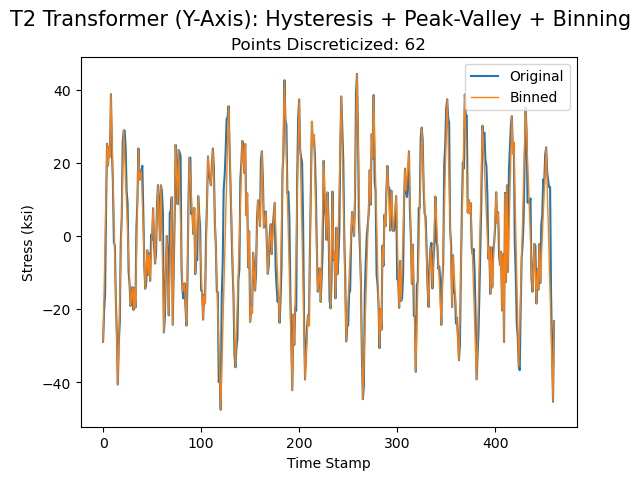

In [28]:
filtered_bin, input_bin, output_bin = binning( filtered_pv, max_bin )

# Generates a the filtered curve over the original curve
plt.plot(df_time["Stress, Real (ksi)"], label = 'Original')
plt.plot(filtered_bin, label = 'Binned', linewidth=1)
plt.legend()
plt.xlabel("Time Stamp")
plt.ylabel("Stress (ksi)")

# Names the title and puts the data on the filtered data as the subtitle for quick verification
plt.suptitle(file_name_core + ": Hysteresis + Peak-Valley + Binning", fontsize = 15)
plt.title("Points Discreticized: "+str(input_bin-output_bin))

# Saves the figure in the 'Individual Pictures' folder
os.chdir(ind_pic_path)
plt.savefig(file_name_core+' - Hyst + PV + Bin.png')
plt.show()

# Rainflow Matrix

Generates the Rainflow Matrix used to calculate the number of stress cycles a component experiences in order to use Miner's Rule.

## Four-Point Counting Method

Counts the number and magnitude of the stress cycless in the post-processed time-domain curve using the 4-point counting method described in ASTM E 1049-85.

Four-point counting is performed using the following steps:

    1. Choose four consecutive stress (S1, S2, S3, S4)
    2. Define the Inner Stress (S2 minus S3)
    3. Define the Outer Stress (S1 minus S4)
    4. Cycle (S2 -> S3) is complete if Inner Stress <= Outer Stress OR incomplete if Inner Stress > Outer Stress

If the Inner Stress is less than or equal to the Outer Stress region, this counts as one complete cycle. A rainflow matrix is an n x n matrix (where n is the number of discretized bins) where the y-axis is the 'from' stress/bin and the x-axis is the 'to' stress/bin. In this case, you would add a count to the matrix coordinates (S2, S3). Once this is marked, you would remove the S2 and S3 data points from the curve and repeat the check with the next, remaining consecutive four points. 

Figure: Full cycle count

For example, if we had stress points (S1, S2, S3, S4, S5, S6, S7, S8), we would do our first four-pointing counting with points S1, S2, S3, S4. Then if we determine that there was one full cycle in these four points, then we would add a count to (S2, S3) in the rainflow matrix then remove them from the data points. This would make our next four-point counting check using the points (S1, S4, S5, S6) and repeat.

If the Inner Stress is greater than the Outer Stress, then this is an incomplete cycle. No counts would be marked, but instead the first of the four points (S1) being checked would be marked as a 'residual' and removed. From there, the four-point counting method would resume with the next, remaining consecutive four points. 

Figure: Incomplete cycle count

Continuing from the example, say that the points we are now looking at are (S1, S4, S5, S6). If we found that these four points have an incomplete cycle, then we would mark point S1 as a 'residual' and remove it from the data. This would make the next four data points we check (S4, S5, S6, S7).

Figure: Residuals

This checking for complete cycles and residuals will continue until all identifiable cycles are removed and counted for. 

The rainflow matrix is still not complete after this - we still need to account for the full time range (assuming the frequency response curve the time-domain curve was derived from is only for one cycle) and process the residuals.

In [29]:
def four_point_counting_method( data, bin ):
    # Creates copy of data to make sure original is intact
    ftr = data.copy(deep=True)

    # Initializes a disctionary to store the values and kets
    matrix_dict = dict()
    s = [0, 1, 2, 3]
    
    # Calculates the bins across the time-domain data
    matrix_len = numpy.arange(data.min(), data.max()+bin, bin).round(5)
    idx = data.keys()

    # Initializes a disctionary to store the values and kets
    matrix_dict = dict()
    for f in matrix_len:
        matrix_dict[f] = dict()
        for t in matrix_len:
            matrix_dict[f][t] = 0

    while s[3] < len(idx):                
        # Select four consectuive data points
        Z = [ ftr[idx[i]].round(5) for i in s ]

        # Checks to see if inner points (1 & 2) are bounded by the outer points (0 & 3)
        if  (Z[0] <= Z[1] and Z[0] <= Z[2] and Z[1] <= Z[3] and Z[2] <= Z[3]) or \
            (Z[3] <= Z[1] and Z[3] <= Z[2] and Z[1] <= Z[0] and Z[2] <= Z[0]):
            
            # Complete Cycle
            matrix_dict[Z[1]][Z[2]] += 1

            # If they are bounded, removes the inner points from the next round of counting
            idx = idx.drop(idx[s[1]])
            idx = idx.drop(idx[s[2]])

            # Then restarts the cycle
            s = [0, 1, 2, 3]
            
        else:
            # Incomplete Cycle
            s[0] = s[1]
            s[1] = s[2]
            s[2] = s[3]
            s[3] = s[3] + 1
            # If not, then shifts all points up by one - leaving the first point as a residual

    # Removes all of the points that were counted as a full cycle - leaving only the residues
    ftr.drop(set(data.keys())-set(idx),inplace=True)
    
    return matrix_dict, ftr

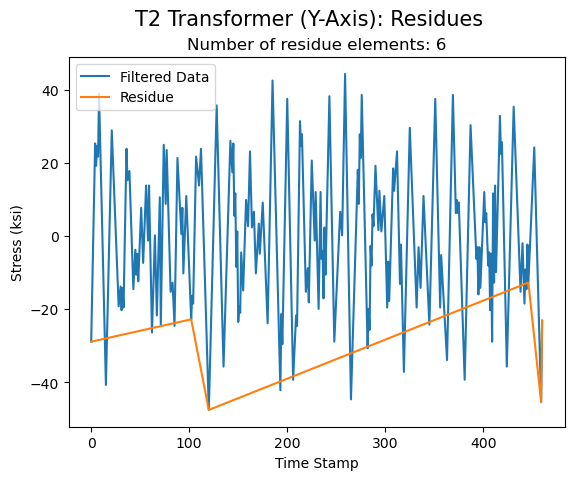

In [30]:
matrix_dict, residue = four_point_counting_method( filtered_bin, max_bin )

# Plots the residues over the filtered data
plt.plot(filtered_bin, label = 'Filtered Data')
plt.plot(residue, label = 'Residue')
plt.legend()
plt.xlabel("Time Stamp")
plt.ylabel("Stress (ksi)")

# Names the title and puts the number of residues as the subtitle for quick verification
plt.suptitle(file_name_core + ": Residues", fontsize = 15)
plt.title("Number of residue elements: " + str(len(residue)))

# Saves the figure in the 'Individual Pictures' folder
os.chdir(ind_pic_path)
plt.savefig(file_name_core + ' - Hyst + PV + Bin - Residues.png')
plt.show()

## Rainflow Matrix

After the four-point counting, we put the data of the main stress cycle counts from the time-domain in a scatterplot (which is the traditional way to view this data). The y-axis depicts the from-stress and the x-axis depicts the to-stress and the color of the point indicates how many times that particular stress cycle occurred. 

Looking at the color scale of the points, it is important to note that despite the counts having decimal places, these counts are DISCRETE INTEGERS and are usually of a low count (<10 from my experience of writing this). This is because the Rainflow Matrix shown below only indicates the stress cycles for ONE window of the input curve. In other words, if we are looking at a 2000-Hz max input signal, this will equate to roughly 0.1 seconds - but our full time span is for 2 or 3 minuts usually. The results shown below only depict the stress cycles for the 0.1 second window, so to get the full number of cycles, we simply just multiply the counts by the number of windows there are in the full time span.

For reference, the complete stress cycle counts will be the total number of stress cycles from the Rainflow Matrix plot (after multipying the counts by the number of windows in the time span) PLUS the counts of the Residuals. This will be summarized later and recorded in the final excel sheet. 

In [31]:
def plot_rainflow_matrix(matrix_dict, cycle_loop, title):

    # Calculates the limits so there is an appropriate level of zooming-in
    lims = (stress_min, stress_max)

    # Initializes new matrix to hold the number of rainflow counts each to- and from- stress has
    rainflow_matrix = []
    
    # Checks every point inside the matrix for the rainflow count
    for f in matrix_dict:
        for t in matrix_dict[f]:
            nonzero = matrix_dict[f][t]
            if nonzero != 0:
                rainflow_matrix.append( [f, t, matrix_dict[f][t]] )

    # Creates a dataframe that has the to- stress, from- stress, and the corresponding rainflow count
    last_df = pandas.DataFrame(rainflow_matrix, columns=["from", "to", "count"])

    # Plots the rainflow matrix as a scatterplot
    plot = last_df.plot.scatter(x="to",
                                y="from",
                                s=7,
                                c="count",
                                xlabel="to (ksi)",
                                ylabel="from (ksi)",
                                grid=False,
                                colormap=cmaps.burg,
                                sharex=False,
                                xlim=lims,
                                ylim=lims,
                                zorder=1)
    plt.title("Cycles in Time Range: " + str(cycle_loop), fontsize=10)
    plt.suptitle(title + " Per Cycle", fontsize=15)

    # Saves the figure in the 'Individual Pictures' folder
    plot.figure.savefig(file_name_core + " - Rainflow Matrix.png")
    
    return rainflow_matrix

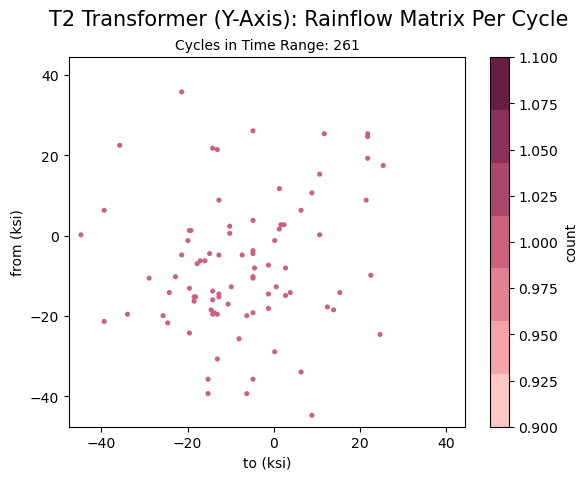

In [32]:
# Count how many times the time-domain repeats in the full cycle
# Defined in the 'Residuals' section
time_loop = math.ceil(full_time / time_max)

os.chdir(ind_pic_path)
rainflow_matrix = plot_rainflow_matrix( matrix_dict, time_loop, file_name_core + ": Rainflow Matrix")

## Rainflow Histogram

The data from the scatterplot can be difficult to read since the scaling is very small and the color of the points aren't discrete colors. The scatterplot is just the more traditional way of visualizing this data, and is more so to help track patterns. A histogram would be better to get exact values from - which is what we need if we are to multiply their values by the number of windows in the time span to use with Miner's Rule to calculate the accumulated damage of the system. 

In [33]:
def comprehensive_rainflow( rainflow, residual, time_looper ):

    complete = []
    for i in range(len(rainflow)-1):
        complete.append( (rainflow[i] * time_looper) + residual[i] )

    return complete

In [34]:
def rainflow_hist(matrix, cycle_loop):

    # Initializes new list to store the calculated data from the rainflow matrix
    rainflow_info_table = list()

    # Goes through the rainflow matrix and calculates the rainflow count, average stress value, and stress amplitude
    for f, t, c in matrix:
        rainflow_info_table.append([c, (f+t)/2, abs(t-f) ])
    rainflow_info_table = numpy.array([info for info in rainflow_info_table if info[0] != 0])

    # List of the 1) Count, 2) Average Stress Values, 3) Stress Amplitudes
    n, S_m, S_a = rainflow_info_table[:,0], rainflow_info_table[:,1], rainflow_info_table[:,2]

    # Plots the histogram
    hist_values, hist_bins, hist_bars = plt.hist(S_a, bins=10, color='skyblue', edgecolor='black')
    plt.bar_label(hist_bars)
    plt.xlabel("Stress Range (ksi)")
    plt.ylabel("Full Cycle Count")
    plt.suptitle(file_name_core + ' - Stress Range Distribution', fontsize=15)
    plt.title("Cycles in Time Range: " + str(cycle_loop), fontsize=10)

    # Saves the figure in the 'Individual Pictures' folder
    os.chdir(ind_pic_path)
    plt.savefig(file_name_core+' - Stress Ranges.png')
    plt.show()

    return hist_values, hist_bins, hist_bars

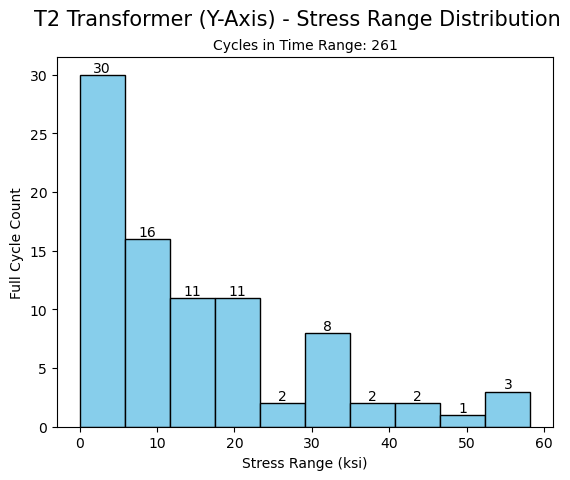

In [35]:
rainflow_hist_counts, rainflow_hist_bins, rainflow_hist_bars = rainflow_hist(rainflow_matrix, time_loop)

# Residuals

The residuals from the four-point counting method represent the largest unclosed cycles present in the time-domain curve. 

If the frequency response curve that the syenthesized time-domain data was generated from was for only one cycle, then some of the resiudals can still be closed. This is because if the time-domain data shown is only for one cycle, then the next cycle is going to occur right after it - which repeats for however many cycles specified. This would also mean that the cycles that were counted so far in the rainflow matrix would occur again - essentially adding another count to all of the current rainflow matrix points. 

For example, if the time-domain time range is only for 0.1 seconds and the actual system is to undergo 10 minutes of this profile, we can say that there will be c=100 cycles. This would mean that the following would occur in the presented order:

    1. A new residual matrix would be created where the residual matrix is repeated (or appended) c times
    2. All the counts in the rainflow matrix would be MULTIPLIED by c
    3. Four-point counting would be conducted on this new residual matrix

The fact that the residual matrix is repeated/appended means that that there is a chance that some of these unclosed cycles can close. With the new residual matrix, four-point counting can be conducted again - adding on to the rainflow matrix.

The 'four_point_residuals' function takes in the residual data, original synthesized time-domain data, and the bin size to calculate the number of stress cycles that come from repeating the residuals n times using the four-point counting method. And this makes sense since if we consider the original frequency is just a window of the full time span that the system is going to be exposed to. We will be assuming that this window repeats across the entire time-span range, which means that these stress cycles and residuals will repeat. 

In [36]:
# Append the residual matrix 'time_loop" number of times
new_residual = []
time_loop_count = 0
while time_loop_count < time_loop:
    for i in residue:
        new_residual.append(round(i, 3))
    time_loop_count += 1

# Creates a Series to run the 'four_point_counting_method' function
residual_appended = pandas.Series(new_residual)

In [37]:
def four_point_residuals( data, bin, original ):
    # Creates copy of data to make sure original is intact
    re_ftr = data.copy(deep=True)

    # Initializes a dictionary to store the values and kets
    re_dict = dict()
    s = [0, 1, 2, 3]
    
    # Calculates the bins across the time-domain data
    re_len = numpy.arange(original.min(), original.max()+bin, bin).round(5)
    idx = data.keys()

    # Initializes a disctionary to store the values and kets
    re_dict = dict()
    for f in re_len:
        re_dict[f] = dict()
        for t in re_len:
            re_dict[f][t] = 0

    while s[3] < len(idx):                
        # Select four consectuive data points
        Z = [ re_ftr[idx[i]].round(5) for i in s ]

        # Checks to see if inner points (1 & 2) are bounded by the outer points (0 & 3)
        if  (Z[0] <= Z[1] and Z[0] <= Z[2] and Z[1] <= Z[3] and Z[2] <= Z[3]) or \
            (Z[3] <= Z[1] and Z[3] <= Z[2] and Z[1] <= Z[0] and Z[2] <= Z[0]):
            
            # Complete Cycle
            re_1 = min(re_len, key=lambda x:abs(x-Z[1]))
            re_2 = min(re_len, key=lambda x:abs(x-Z[2]))
            re_dict[re_1][re_2] += 1

            # If they are bounded, removes the inner points from the next round of counting
            idx = idx.drop(idx[s[1]])
            idx = idx.drop(idx[s[2]])

            # Then restarts the cycle
            s = [0, 1, 2, 3]
            
        else:
            # Incomplete Cycle
            s[0] = s[1]
            s[1] = s[2]
            s[2] = s[3]
            s[3] = s[3] + 1
            # If not, then shifts all points up by one - leaving the first point as a residual

    # Removes all of the points that were counted as a full cycle - leaving only the residues
    re_ftr.drop(set(data.keys())-set(idx),inplace=True)
    
    return re_dict, re_ftr

## Residuals Matrix

The 'four_point_residuals' function will output a matrix where each entry has three data points: the 'from' stress, the 'to' stress, and the number of times a cycle with the exact from-to stress magnitude occurred. The results can be displayed in a scatterplot where the x-axis is the to-stress, the y-axis is the from-stress, and the color of the the point depicts the number of times that particular stress cycle occurred. 

It's important to note that the residual matrix will not have as many discrete points as the regular rainflow matrix does - but instead should have a few points with high counts. And this makes sense since the appended residual matrix is just the same set of data points repeated over and over. If there are not a lot of residuals in one iteration of the synthesized time-domain data, then there would not be a lot of discrete points in the appended version either. Instead, it is more important to note the count/color of the residual scatterplot.

In [38]:
def plot_residual_rainflow(matrix_dict, cycle_time):

    # Calculates the limits so there is an appropriate level of zooming-in
    lims = (stress_min, stress_max)

    # Initializes new matrix to hold the number of rainflow counts each to- and from- stress has
    rainflow_matrix = []
    
    # Checks every point inside the matrix for the rainflow count
    for f in matrix_dict:
        for t in matrix_dict[f]:
            nonzero = matrix_dict[f][t]
            if nonzero != 0:
                rainflow_matrix.append( [f, t, matrix_dict[f][t]] )

    # Creates a dataframe that has the to- stress, from- stress, and the corresponding rainflow count
    last_df = pandas.DataFrame(rainflow_matrix, columns=["from", "to", "count"])

    # Plots the rainflow matrix as a scatterplot
    plot = last_df.plot.scatter(x="to",
                                y="from",
                                s=7,
                                c="count",
                                xlabel="to (ksi)",
                                ylabel="from (ksi)",
                                grid=False,
                                colormap=cmaps.burg,
                                sharex=False,
                                xlim=lims,
                                ylim=lims,
                                zorder=1)
    plt.title(file_name_core + ": Appended Residuals", fontsize=15)
    
    # Saves the figure in the 'Individual Pictures' folder
    plot.figure.savefig(file_name_core + " - Appended Residuals.png")
    
    return rainflow_matrix

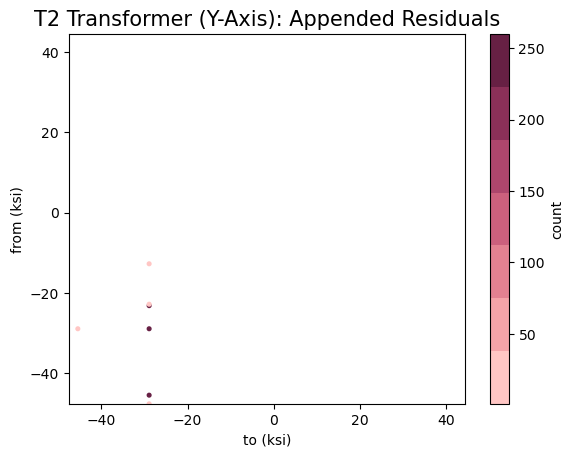

In [39]:
residual_dict, residual_ftr = four_point_residuals( residual_appended, max_bin, filtered_bin )

os.chdir(ind_pic_path)
residual_matrix = plot_residual_rainflow( residual_dict, time_loop)

## Residual Histogram

The data from the scatterplot can be difficult to read since the scaling is very small and the color of the points aren't discrete colors. The scatterplot is just the more traditional way of visualizing this data, and is more so to help track patterns. A histogram would be better to get exact values from - which is what we need if we use Miner's Rule to calculate the accumulated damage of the system. 

In [40]:
def residuals_hist(matrix):

    # Initializes new list to store the calculated data from the rainflow matrix
    rainflow_info_table = []

    # Finds the stress magniutude and puts it into a matrix the number of times it appears in the appended residual data
    for h, l, c in matrix:
        for r in range(c):
            rainflow_info_table.append( abs(h-l) )

    # Plots the histogram
    his_values, his_bins, his_bars = plt.hist(rainflow_info_table, bins=10, color='skyblue', edgecolor='black')
    plt.bar_label(his_bars)
    plt.xlabel("Stress Range (ksi)")
    plt.ylabel("Full Cycle Count")
    plt.title(file_name_core + ' - Residual Stress Distribution', fontsize=15)

    # Saves the figure in the 'Individual Pictures' folder
    os.chdir(ind_pic_path)
    plt.savefig(file_name_core+' - Appended Residuals Ranges.png')
    plt.show()

    return his_values, his_bins, his_bars

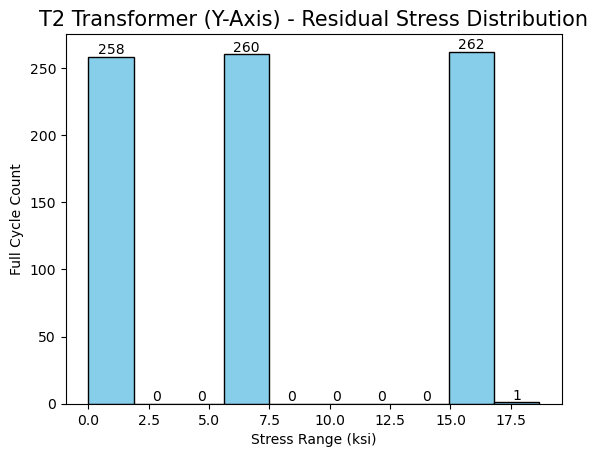

In [41]:
residuals_hist_counts, residuals_hist_bins, residuals_hist_bars = residuals_hist(residual_matrix)

# Complete Stress Cycle Count

To use Miner's rule, we need to find out how many times a component experiences cyclic loading, and to what magnitude. 

The first thing we do is find out how many windows there are in the full time span. For instance, if we are talking about a 2,000-Hz range input signal, this means that one window is roughly 0.1 seconds. And if we are to undergo this profile for say 2 minutes, then we assume the cycle is just repeating, meaning that there will be: 2 min -> 120 sec / 0.1 sec = 1200 cycles.

Aftwe we find out how many cycles there are, we perform the four-point counting method on the time-domain curve to get a Rainflow Matrix count and a Residual count. 

With the Rainflow matrix count,  the results shown will only be the counts inside that 0.1 sec window. To get the full number of cycles, we simply mutiply ALL the counts in the Rainflow Matrix with the number of windows there are in the time span. 

We cannot forget about the Residuals either. The Residuals represent the largest unclosed cycles in the input signal. Since we are assuming our window is repeating across the entire time span, this means these residual points will be repeated the same number of times the window repeats in the full time span range. To take the Residuals into account, we essentially make a new list of points where the residuals are repeated over and over - for instance, say the Residual has points ABCDE, the appended Residual matrix will look like ABCDEABCDEABCDE... and so forth. Once a new appended Residual list is made, we perform the four-point counting method again - but just on this appended Residual list. The results are then ADDED to the full Rainflow Matrix count. 

The total number of cycles is calculated by adding the FULL Rainflow matrix count with the results of conducting the four-point method on the APPENDED Residual matrix. These results are saved in a list and will be recorded in the final excel sheet for easier post-processing. 

In [42]:
def comprehensive_rainflow( rainflow_counts, rainflow_bins, residual, time_looper ):

    # Calculates FULL Rainflow Matrix counts by multiplying the counts of the Rainflow matrix with the number of windows
    res_binning = []
    for k in rainflow_counts:
        res_binning.append(k * time_looper)

    # Conducts four-point counting method on the Appended Residual matrix (Appended Residual matrix is the input)
    # Adds the results to the Full Rainflow Matrix Counts
    for i in range(len(rainflow_bins)-1):
        for j in residual:
            # Calculates the range of the stress bins
            final_valuer = 0
            final_residual = abs(j[1] - j[0])

            # Sorts the residuals into the appropriate bins (representing magnitude of the cycle)
            if final_residual >= rainflow_bins[i] and final_residual <= rainflow_bins[i+1]:

            # Adds the residual count to the FULL Rainflow Matrix count
                final_valuer = j[2] 
            
            else:
            # Otherwise just leaves the count as is
                final_valuer = 0
            
            res_binning[i] += final_valuer

    return res_binning

In [43]:
complete_rainflow = comprehensive_rainflow( rainflow_hist_counts, rainflow_hist_bins, residual_matrix, time_loop )

# Post-Processing

Formats all the pictures and graphs for easier copy-pasting into the report

## Reading the 'Individual Pictures' folder

Gets the 'Individual Pictures' folder and makes a call-able list of all the files in it

In [44]:
# Put all the names of the pictures in a list
os.chdir(ind_pic_path)
pic_list = os.listdir()
pic_index = numpy.arange(len(pic_list))

## Frequency- and Time- Domain Curves

Displays the original PSD curve and transformed time-domain curves next to each other.

In [46]:
# Create the picture for the frequency- and time- domain curves

# Get the images from the folder
domain_2 = Image.open(pic_list[2])
domain_11 = Image.open(pic_list[11])

# Get the height and width of each of the images
w_d2, h_d2 = domain_2.size
w_d11, h_d11 = domain_11.size

# Calculate the size of the new image
domain_width =  max(w_d2, w_d11)
domain_height = max(h_d2, h_d11)

# Create a big empty image with place for iamges
domain_curves = Image.new('RGB', (domain_width*2, domain_height))

# Put images on the new image
domain_curves.paste(domain_2, (0,0))
domain_curves.paste(domain_11, (domain_width,0))

# Saves the formatted picture in the part's main folder
os.chdir(prt_pic_path)
domain_curves.save(file_name_core + ' - Domain Curves.png')
os.chdir(ind_pic_path)

## Data Filtering Progression

Shows the progression from the original fft time-domain curve: hysteresis filtering -> peak-valley-filtering -> discretization -> residues

In [47]:
# Create the picture for the filtering progression

# Get the images from the folder
filtering_8 = Image.open(pic_list[8])
filtering_7 = Image.open(pic_list[7])
filtering_6 = Image.open(pic_list[6])
filtering_5 = Image.open(pic_list[5])

# Get the height and width of each of the images
w_f8, h_f8 = filtering_8.size
w_f7, h_f7 = filtering_7.size
w_f6, h_f6 = filtering_6.size
w_f5, h_f5 = filtering_5.size

# Calculate the size of the new image
filtering_width =  max(w_f8, w_f7, w_f6, w_f5)
filtering_height = max(h_f8, h_f7, h_f6, h_f5)

# Create a big empty image with place for iamges
filtering_progression = Image.new('RGB', (filtering_width*2, filtering_height*2))

# Put images on the new image
filtering_progression.paste(filtering_8, (0,0))
filtering_progression.paste(filtering_7, (filtering_width,0))
filtering_progression.paste(filtering_6, (0,filtering_height))
filtering_progression.paste(filtering_5, (filtering_width,filtering_height))

# Saves the formatted picture in the part's main folder
os.chdir(prt_pic_path)
filtering_progression.save(file_name_core + ' - Filtering Progression.png')
os.chdir(ind_pic_path)

## Rainflow Results

Displays the scatterplot and histogram charts for the regular rainflow matrix (one cycle) and residuals.

In [48]:
# Create Rainflow matrix Results Picture
os.chdir(ind_pic_path)

# Get the images from the folder
rfm_res_9 = Image.open(pic_list[9])
rfm_res_12 = Image.open(pic_list[12])
rfm_res_1 = Image.open(pic_list[1])
rfm_res_0 = Image.open(pic_list[0])

# Get the height and width of each of the images
w_rfm9, h_rfm9 = rfm_res_9.size
w_rfm12, h_rfm12 = rfm_res_12.size
w_rfm1, h_rfm1 = rfm_res_1.size
w_rfm0, h_rfm0 = rfm_res_0.size

# Calculate the size of the new image
rfm_res_width =  max(w_rfm0, w_rfm1, w_rfm9, w_rfm12)
rfm_res_height = max(h_rfm0, h_rfm1, h_rfm9, h_rfm12)

# Create a big empty image with place for iamges
rfm_results = Image.new('RGB', (rfm_res_width*2, rfm_res_height*2))

# Put images on the new image
rfm_results.paste(rfm_res_9, (0,0))
rfm_results.paste(rfm_res_12, (rfm_res_width,0))
rfm_results.paste(rfm_res_1, (0,rfm_res_height))
rfm_results.paste(rfm_res_0, (rfm_res_width,rfm_res_height))

# Saves the formatted picture in the part's main folder
os.chdir(prt_pic_path)
rfm_results.save(file_name_core + ' - Rainflow Results.png')

## Excel of all Time- and Frequency Curves

Puts data from the frequency input (basically the Solidworks frequency response graph), the synthesized time-domain curves (the rng phase angles more importantly in case we want to re-create the data), and time-domain calculations (for a description of the curve) into separate tabs of an excel sheet.

In [49]:
def comprehensive_rainflow( rainflow_counts, rainflow_bins, residual, time_looper ):

    res_binning = []
    for k in rainflow_counts:
        res_binning.append(k * time_looper)
    
    for i in range(len(rainflow_bins)-1):
        for j in residual:
            final_valuer = 0
            final_residual = abs(j[1] - j[0])
            if final_residual >= rainflow_bins[i] and final_residual <= rainflow_bins[i+1]:
                final_valuer = j[2] 
            else:
                final_valuer = 0
            res_binning[i] += final_valuer

    return res_binning

In the first tab, we will put in the complete stress cycle counts (the exact number of cycles and corresponding magnitudes) to be used in the calculation for Miner's rule. These values can be used as is - after determing the principal stress range to use.

In [50]:
complete_rainflow = comprehensive_rainflow( rainflow_hist_counts, rainflow_hist_bins, residual_matrix, time_loop )

In [51]:
os.chdir(prt_pic_path)

# Creates a list of the stress ranges used in the rainflow histogram
stress_range_name = []
for i in range(len(rainflow_hist_bins)-1):
    stress_range_name.append(str(round(rainflow_hist_bins[i],3)) + " - " + str(round(rainflow_hist_bins[i+1],3)))

# Creates a list of the stress range counts used in the rainflow histogram
stress_range_count = []
for j in complete_rainflow:
    stress_range_count.append(round(j))

# Creates a dataframe of the stress range counts and bin sizes that we just made
rainflow_counts = {'Stress Range (ksi)': stress_range_name, 'Cycle Counts': stress_range_count}
cycle_counts = pandas.DataFrame(rainflow_counts)

# Creates a dataframe using the time-domain analysis data back from the 'General Data' section
analysis_summary = {'Feature':result_titles,'Cycle Counts':result_values}
comp_summary = pandas.DataFrame(analysis_summary)

# Creates a tab inside of an excel sheet for with the time-domain, frequency-domain, general data, and rainflow counts
writer = pandas.ExcelWriter(file_name_core + ' - Analysis Results.xlsx', engine = 'xlsxwriter')
cycle_counts.to_excel(writer, sheet_name = 'Stress Cycle Counts', index=False)
comp_summary .to_excel(writer, sheet_name = 'Analysis Summary', index=False)
df_freq.to_excel(writer, sheet_name = 'Frequency-Domain Data', index=False)
df_time.to_excel(writer, sheet_name = 'Time-Domain Data', index=False)

# Saves the formatted picture in the part's main folder
writer.close()
os.chdir(main_dir)